# Analisi della Correlazione tra Sentiment delle Notizie e Prezzo di Bitcoin

**Nome:** Alessandro Zucchiatti
**Corso:** Fondamenti di Analisi Dati e Laboratorio
**Progetto:** Analisi del sentiment e dell'andamento di prezzo di Bitcoin

### Obiettivo
Investigare la relazione tra il sentiment delle notizie su Bitcoin e l'andamento del prezzo giornaliero tramite feature engineering e modelli statistici.

**Domanda di ricerca:** Esiste una correlazione statisticamente significativa tra il sentiment aggregato giornaliero delle notizie e la variazione percentuale del prezzo di Bitcoin del giorno successivo?

### Setup e Import Librerie

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ast
import kagglehub
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import grangercausalitytests

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['figure.dpi'] = 100

print("Librerie importate con successo!")

Librerie importate con successo!


### Caricamento e Preparazione dei Dati

In [47]:
# Caricamento dataset sentiment
path = kagglehub.dataset_download('oliviervha/crypto-news')
file_path = path + "/cryptonews.csv"

try:
    sentiment_df = pd.read_csv(file_path)
    print("Dataset del sentiment caricato.")
    display(sentiment_df.head())
except FileNotFoundError:
    print(f"Errore: File '{file_path}' non trovato.")

Dataset del sentiment caricato.


,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [28]:
# Filtraggio e pulizia dati sentiment
btc_sentiment_df = sentiment_df[sentiment_df['subject'] == 'bitcoin'].copy()

def parse_sentiment(sentiment_str):
    try:
        return ast.literal_eval(sentiment_str)
    except (ValueError, SyntaxError):
        return {'class': 'neutral', 'polarity': 0.0, 'subjectivity': 0.0}

sentiment_dicts = btc_sentiment_df['sentiment'].apply(parse_sentiment)
btc_sentiment_df['sentiment_class'] = [d.get('class', 'neutral') for d in sentiment_dicts]
btc_sentiment_df['polarity'] = [d.get('polarity', 0.0) for d in sentiment_dicts]
btc_sentiment_df['subjectivity'] = [d.get('subjectivity', 0.0) for d in sentiment_dicts]
btc_sentiment_df['date'] = pd.to_datetime(btc_sentiment_df['date'])
btc_sentiment_df = btc_sentiment_df[['date', 'sentiment_class', 'polarity', 'subjectivity']]

print("Pulizia dati sentiment completata.")
display(btc_sentiment_df.head())

Pulizia dati sentiment completata.


,date,sentiment_class,polarity,subjectivity
5,2023-12-19 05:25:00,negative,-0.01,0.38
6,2023-12-19 04:50:11,positive,0.30,0.10
7,2023-12-19 04:10:00,neutral,0.00,0.00
9,2023-12-19 02:59:59,negative,-0.08,0.64
21,2023-12-18 18:33:34,negative,-0.27,0.33


In [29]:
# Caricamento dati prezzo Bitcoin
start_date = btc_sentiment_df['date'].min().strftime('%Y-%m-%d')
end_date = (btc_sentiment_df['date'].max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

btc_price_df = yf.download('BTC-USD', start=start_date, end=end_date)
btc_price_df['pct_change'] = btc_price_df['Close'].pct_change() * 100
btc_price_df = btc_price_df.reset_index().rename(columns={'Date': 'date'})

print(f"Dati prezzo Bitcoin scaricati dal {start_date} al {end_date}.")
display(btc_price_df.head())

[*********************100%***********************]  1 of 1 completed

Dati prezzo Bitcoin scaricati dal 2021-11-05 al 2023-12-20.


Price,date,Close,High,Low,Open,Volume,pct_change
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,
0,2021-11-05,61125.675781,62541.468750,60844.609375,61460.078125,30605102446,NaN
1,2021-11-06,61527.480469,61590.683594,60163.781250,61068.875000,29094934221,0.657342
2,2021-11-07,63326.988281,63326.988281,61432.488281,61554.921875,24726754302,2.924722
3,2021-11-08,67566.828125,67673.742188,63344.066406,63344.066406,41125608330,6.695155
4,2021-11-09,66971.828125,68530.335938,66382.062500,67549.734375,42357991721,-0.880610


### Aggregazione e Feature Engineering

In [30]:
# Aggregazione sentiment su base giornaliera
btc_sentiment_df.set_index('date', inplace=True)
daily_sentiment = btc_sentiment_df.resample('D').agg(
    polarity_mean=('polarity', 'mean'),
    polarity_std=('polarity', 'std'),
    subjectivity_mean=('subjectivity', 'mean'),
    news_count=('polarity', 'count')
)
daily_sentiment['polarity_std'] = daily_sentiment['polarity_std'].fillna(0)
daily_sentiment = daily_sentiment[daily_sentiment['news_count'] > 0].reset_index()

print("Aggregazione giornaliera completata.")
display(daily_sentiment.head())

Aggregazione giornaliera completata.


,date,polarity_mean,polarity_std,subjectivity_mean,news_count
0,2021-11-05,0.1380,0.138816,0.5420,5
1,2021-11-06,0.0000,0.000000,0.0000,1
2,2021-11-08,-0.0025,0.005000,0.1875,4
3,2021-11-09,0.1600,0.195959,0.4550,4
4,2021-11-10,0.0350,0.083865,0.2525,4


### Unione dei Dati

In [31]:
# Merge dei dataset
daily_sentiment['date'] = daily_sentiment['date'].dt.tz_localize(None)

if isinstance(btc_price_df.columns, pd.MultiIndex):
    btc_price_df.columns = btc_price_df.columns.droplevel(1)

btc_price_df['date'] = pd.to_datetime(btc_price_df['date'])
df_merged = pd.merge(btc_price_df, daily_sentiment, on='date', how='inner')
df_merged = df_merged.dropna().set_index('date')

print(f"Merge completato: {len(df_merged)} righe")
display(df_merged.head())

Merge completato: 755 righe


,Close,High,Low,Open,Volume,pct_change,polarity_mean,polarity_std,subjectivity_mean,news_count
date,,,,,,,,,,
2021-11-06,61527.480469,61590.683594,60163.781250,61068.875000,29094934221,0.657342,0.0000,0.000000,0.0000,1
2021-11-08,67566.828125,67673.742188,63344.066406,63344.066406,41125608330,6.695155,-0.0025,0.005000,0.1875,4
2021-11-09,66971.828125,68530.335938,66382.062500,67549.734375,42357991721,-0.880610,0.1600,0.195959,0.4550,4
2021-11-10,64995.230469,68789.625000,63208.113281,66953.335938,48730828378,-2.951387,0.0350,0.083865,0.2525,4
2021-11-11,64949.960938,65579.015625,64180.488281,64978.890625,35880633236,-0.069651,0.0950,0.190000,0.2050,4


### Analisi Esplorativa e Visualizzazione

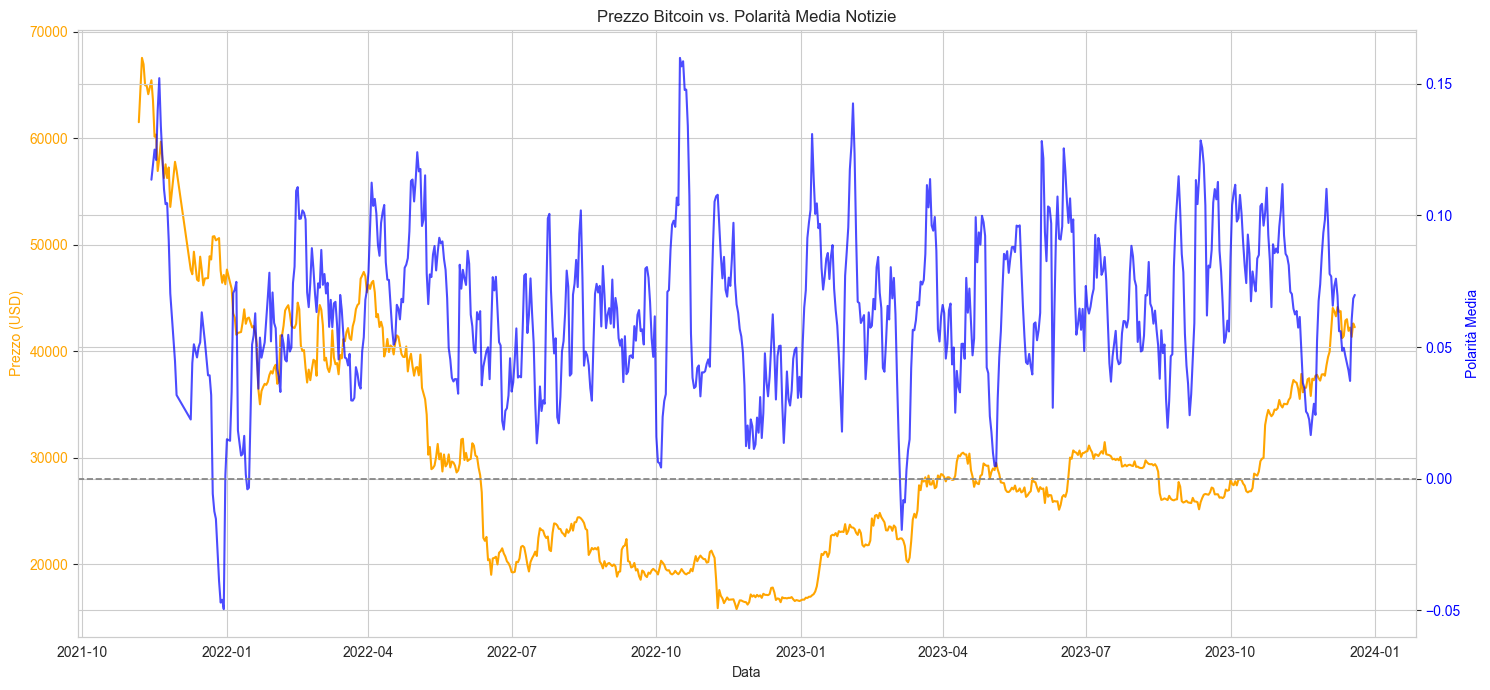

In [32]:
# Andamento prezzo vs polarità
fig, ax1 = plt.subplots()
ax1.plot(df_merged.index, df_merged['Close'], color='orange', label='Prezzo BTC')
ax1.set_xlabel('Data')
ax1.set_ylabel('Prezzo (USD)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(df_merged.index, df_merged['polarity_mean'].rolling(window=7).mean(), 
         color='blue', alpha=0.7, label='Polarità (Media 7gg)')
ax2.set_ylabel('Polarità Media', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1.2)

plt.title('Prezzo Bitcoin vs. Polarità Media Notizie')
fig.tight_layout()
plt.show()

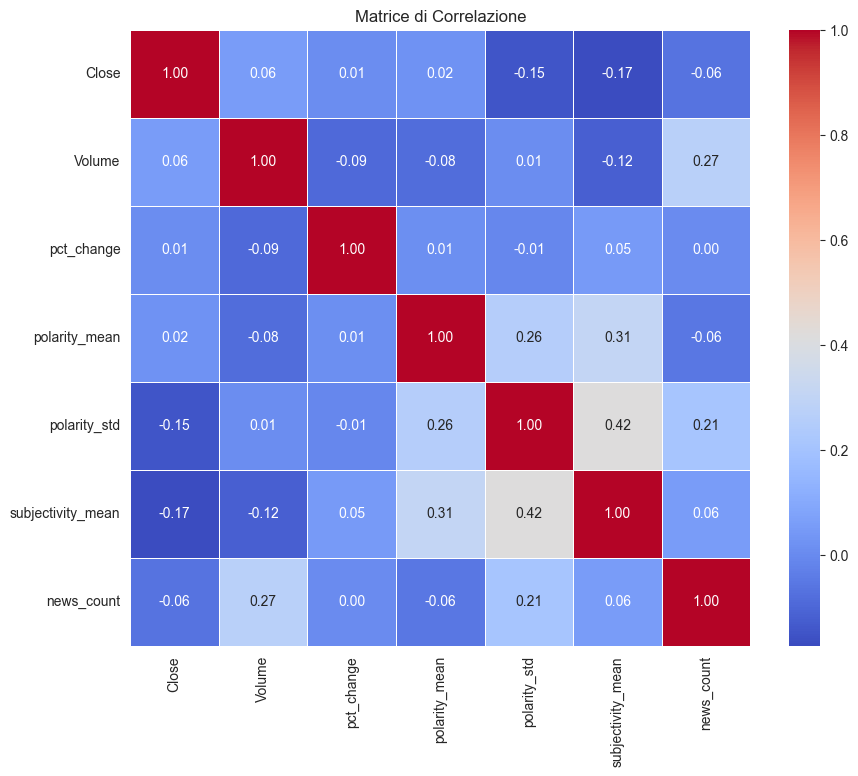

In [33]:
# Matrice di correlazione
correlation_cols = ['Close', 'Volume', 'pct_change', 'polarity_mean', 'polarity_std', 'subjectivity_mean', 'news_count']
correlation_matrix = df_merged[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione')
plt.show()

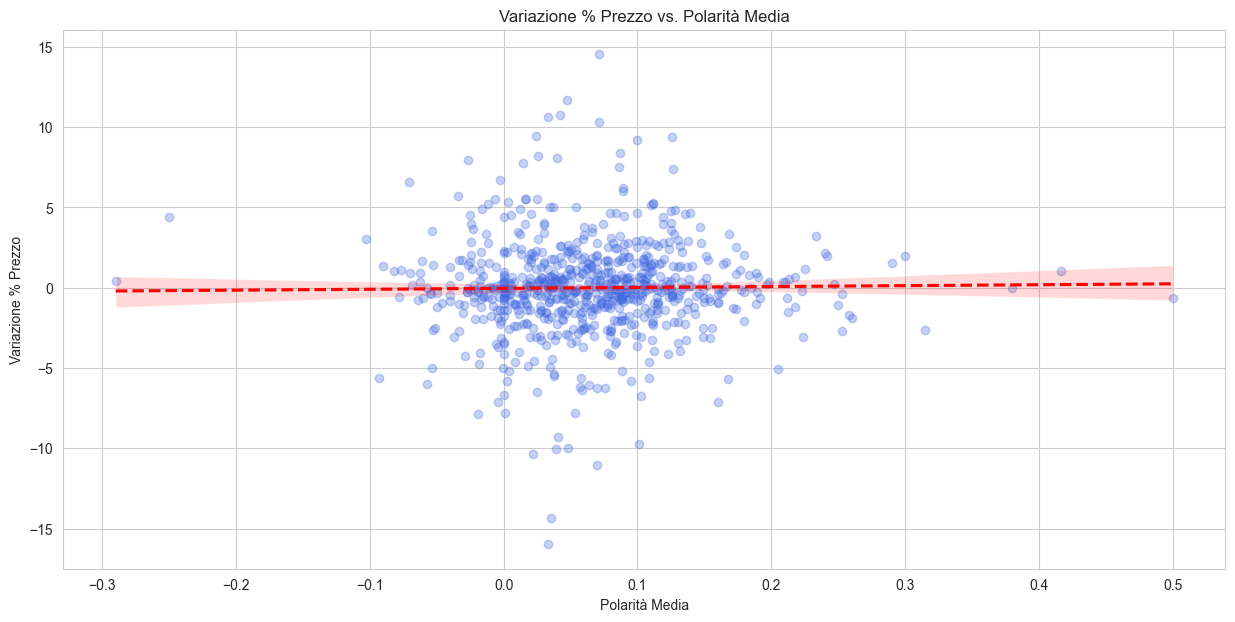

In [34]:
# Scatter plot polarità vs variazione prezzo
sns.regplot(x='polarity_mean', y='pct_change', data=df_merged, 
            scatter_kws={'alpha':0.3, 'color': 'royalblue'}, 
            line_kws={'color':'red', 'linestyle':'--'})
plt.title('Variazione % Prezzo vs. Polarità Media')
plt.xlabel('Polarità Media')
plt.ylabel('Variazione % Prezzo')
plt.show()

### Modellazione Predittiva

In [35]:
# Preparazione dati per modello predittivo
df_model = df_merged.copy()
df_model['target_pct_change'] = df_model['pct_change'].shift(-1)
df_model = df_model.dropna()

features = ['polarity_mean', 'polarity_std', 'subjectivity_mean', 'news_count', 'Volume', 'pct_change']
X = df_model[features]
y = df_model['target_pct_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
print(f"Dataset: {X_train.shape[0]} train, {X_test.shape[0]} test")

Dataset: 603 train, 151 test


In [36]:
# Regressione lineare
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regressione Lineare - MSE: {mse:.4f}, R²: {r2:.4f}")

coeffs = pd.DataFrame(model.coef_, X.columns, columns=['Coefficiente']).sort_values('Coefficiente', ascending=False)
print("\nCoefficienti del modello:")
display(coeffs)

print("\nUn R² basso indica che il modello lineare non spiega efficacemente la variabilità del prezzo.")

Regressione Lineare - MSE: 4.4149, R²: -0.0176

Coefficienti del modello:


,Coefficiente
subjectivity_mean,4.332453e-01
polarity_std,3.277537e-01
polarity_mean,1.979926e-01
Volume,-1.913300e-11
news_count,-2.794934e-03
pct_change,-2.059662e-02



Un R² basso indica che il modello lineare non spiega efficacemente la variabilità del prezzo.


In [38]:
# Test di Causalità di Granger
causality_df = df_merged[['pct_change', 'polarity_mean']].dropna()
max_lag = 7

print(f"Test di Causalità di Granger (max_lag={max_lag})")

try:
    granger_test_result = grangercausalitytests(causality_df, maxlag=max_lag)
    
    p_values = [round(granger_test_result[lag][0]['ssr_ftest'][1], 4) for lag in range(1, max_lag + 1)]
    print(f"\nP-values per lag 1-{max_lag}: {p_values}")
    
    if any(p < 0.05 for p in p_values):
        print("\nRisultato: Evidenza di Causalità di Granger trovata.")
    else:
        print("\nRisultato: Nessuna evidenza di Causalità di Granger.")

except Exception as e:
    print(f"\nErrore test di Granger: {e}")

Test di Causalità di Granger (max_lag=7)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8860  , p=0.3469  , df_denom=751, df_num=1
ssr based chi2 test:   chi2=0.8896  , p=0.3456  , df=1
likelihood ratio test: chi2=0.8890  , p=0.3457  , df=1
parameter F test:         F=0.8860  , p=0.3469  , df_denom=751, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.7330  , p=0.0013  , df_denom=748, df_num=2
ssr based chi2 test:   chi2=13.5560 , p=0.0011  , df=2
likelihood ratio test: chi2=13.4354 , p=0.0012  , df=2
parameter F test:         F=6.7330  , p=0.0013  , df_denom=748, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8768  , p=0.0023  , df_denom=745, df_num=3
ssr based chi2 test:   chi2=14.7678 , p=0.0020  , df=3
likelihood ratio test: chi2=14.6246 , p=0.0022  , df=3
parameter F test:         F=4.8768  , p=0.0023  , df_denom=745, df_num=3

Granger Causality
number of lags (no zero) 4
ssr bas

### Conclusioni

**Risultati principali:**
1. La correlazione diretta tra sentiment e variazione di prezzo nello stesso giorno è molto debole
2. Il modello di regressione lineare mostra performance limitata (basso R²)
3. Il test di Causalità di Granger valuta se il sentiment passato ha valore predittivo

**Considerazioni:** Il mercato Bitcoin è influenzato da molteplici fattori complessi che il solo sentiment delle notizie non riesce a catturare completamente.
